In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install giotto-tda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.2 MB/s eta 0:00:00


In [ ]:
import gtda
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
import plotly.graph_objects as go
from gtda.plotting import plot_point_cloud

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
path = "/content/drive/Shareddrives/datathon/clean_data/Translated_Data.xlsx"

Mounted at /content/drive


In [ ]:
data = pd.read_excel(path)

In [ ]:
data.head()

,Date,NPS,Comment,Channel
0,2023-03-01 04:57:35,8,NO ME DIO LA OPCIÓN DE PAGO A MESES SIN INTERESES,Booking flow
1,2023-03-01 04:55:45,6,MUY TARDADO NO ME LLEGA LA CONFIRMACIÓN VÍA CO...,Booking flow
2,2023-03-01 04:54:40,8,QUE LOS PRECIOS NO SEAN TAN CAROS ESO ATRAERIA...,Booking flow
3,2023-03-01 04:51:03,2,ME ESTAS MANDANDO EL NPS CUANDO TODAVA NI SIQU...,Booking flow
4,2023-03-01 04:48:36,0,NO PUDE PAGAR,Booking flow


In [ ]:
def sentiment(x):
    if x < 7:
        return 'Detractors'
    elif x < 9:
        return 'Passives'
    else:
        return 'Promoters' 

data['Sentiment'] = data['NPS'].apply(sentiment)

In [ ]:
data= data[data['Date'] > '2023-01-11']

In [ ]:
sentiment =data[['Sentiment','Date']]

In [ ]:
detractors= sentiment[sentiment['Sentiment']=='Detractors']
passives = sentiment[sentiment['Sentiment']=='Passives']
promoters = sentiment[sentiment['Sentiment']=='Promoters']

In [ ]:
def return_count(df, date_col = 'Date'):
  s = pd.to_datetime(df[date_col])
  df1 = s.groupby(s.dt.floor('d')).size().reset_index(name='count')
  return df1

In [ ]:
detractors_count = return_count(detractors)
passives_count = return_count(passives)
promoters_count = return_count(promoters)

In [ ]:
def plot_count(df):  
  x=np.array(df.index)
  y=np.array(df.iloc[:, 1])
  plt.plot(x,y)


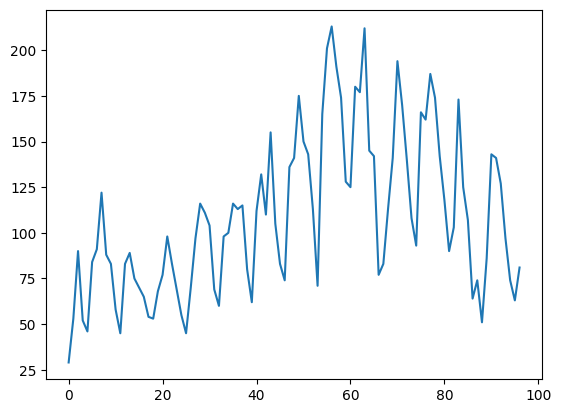

In [ ]:
plot_count(detractors_count)

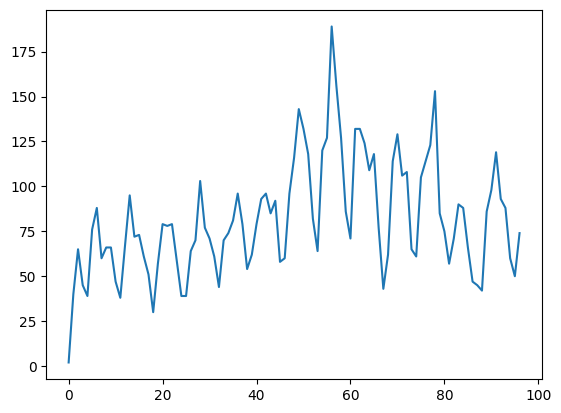

In [ ]:
plot_count(passives_count)

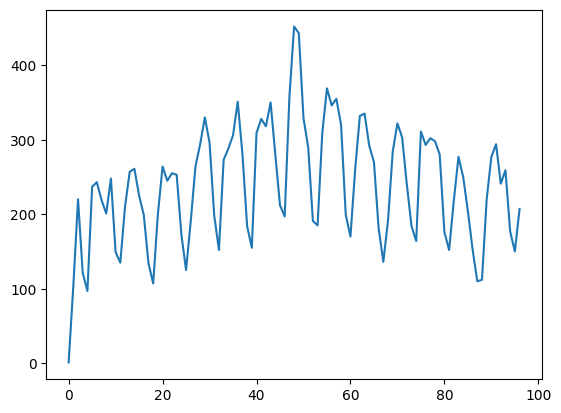

In [ ]:
plot_count(promoters_count)

In [ ]:
def embedding_point_cloud(df): 
  x=np.array(df.index)
  y=np.array(df.iloc[:, 1])

  #escoger parametros óptimos y1
  max_periodic_dimension=9 #raiz de 169
  max_periodic_time_delay=9
  stride=1
  tau,d= takens_embedding_optimal_parameters(y, max_periodic_dimension, max_periodic_time_delay, stride)
  print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

  # Escogemos nuestros parametros para el encaje
  # d= embedding_dimension_periodic
  # tau = embedding_time_delay_periodic
  # stride = nos permite tomar un subconjunto de los datos.
  embedding_dimension_periodic = d
  embedding_time_delay_periodic = tau
  stride = 1

  # Modifica el `stride` y el `delay` para obtener diferentes encajes, de lo anterior.

  embedder_periodic = SingleTakensEmbedding(
      parameters_type="fixed",
      n_jobs=2,
      time_delay=embedding_time_delay_periodic,
      dimension=embedding_dimension_periodic,
      stride=stride,
  )

  y_periodic_embedded = embedder_periodic.fit_transform(y)
  print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
  plot_point_cloud(y_periodic_embedded)
  return y_periodic_embedded

In [ ]:
from gtda.homology import VietorisRipsPersistence
def persistence_diagram(y_periodic_embedded):
  y_periodic_embedded = y_periodic_embedded[None, :, :]
  # 0 - connected components, 1 - loops, 2 - voids
  homology_dimensions = [0, 1]

  contaminantes_persistence = VietorisRipsPersistence(
      homology_dimensions=homology_dimensions, n_jobs=1
  )
  print("Persistence diagram for periodic signal")
  contaminantes_persistence.fit_transform_plot(y_periodic_embedded)

In [ ]:
detract_embed = embedding_point_cloud(detractors_count)
plot_point_cloud(detract_embed)

Optimal time delay:  9 
Optimal dimension:  5
Shape of embedded time series: (61, 5)


In [ ]:
pass_embed = embedding_point_cloud(passives_count)
plot_point_cloud(pass_embed)

Optimal time delay:  2 
Optimal dimension:  4
Shape of embedded time series: (91, 4)


In [ ]:
prom_embed = embedding_point_cloud(promoters_count)
plot_point_cloud(prom_embed)

Optimal time delay:  9 
Optimal dimension:  4
Shape of embedded time series: (70, 4)


In [ ]:
persistence_diagram(detract_embed)

Persistence diagram for periodic signal


In [ ]:
persistence_diagram(pass_embed)

Persistence diagram for periodic signal


In [ ]:
persistence_diagram(prom_embed)

Persistence diagram for periodic signal
